In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from collections import Counter

import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.over_sampling import SMOTE,ADASYN
from sklean.combine import SMOTETomek,SMOTEENN
from sklearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn.over_sampling'

In [3]:
# Import Dataset
df = pd.read_csv('Fraud_check.csv')
df

Undergrad Marital.Status  Taxable.Income  City.Population  \
0          NO         Single           68833            50047   
1         YES       Divorced           33700           134075   
2          NO        Married           36925           160205   
3         YES         Single           50190           193264   
4          NO        Married           81002            27533   
..        ...            ...             ...              ...   
595       YES       Divorced           76340            39492   
596       YES       Divorced           69967            55369   
597        NO       Divorced           47334           154058   
598       YES        Married           98592           180083   
599        NO       Divorced           96519           158137   

     Work.Experience Urban  
0                 10   YES  
1                 18   YES  
2                 30   YES  
3                 15   YES  
4                 28    NO  
..               ...   ...  
595                7   YES  
596                2   YES  
597                0   YES  
598               17    NO  
599               16    NO  

[600 rows x 6 columns]

In [4]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [5]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [6]:
df.shape

(600, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [8]:
df[df.duplicated()].shape

(0, 6)

In [9]:
df[df.duplicated()]

Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []

In [10]:
df.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

The features are not on the same scale. For example `City.Population` has a mean of `108747.36` while `Work.Experience` has a mean value of `15.55`. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check further.

### 3.2 Feature Engineering<a class="anchor" id="3.2"></a>

[Table of Contents](#0.1)

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [11]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban taxable_category  
0   YES             Good  
1   YES             Good  
2   YES             Good  
3   YES             Good  
4    NO             Good

In [12]:
categorical_features = df.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [13]:
numerical_features = df.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## 4. Data Visualization<a class="anchor" id="4"></a>

[Table of Contents](#0.1)

+ ###  Univariate plots<a class="anchor" id="4.1"></a>

Next let's get the distribution of animal data across the types of classes.

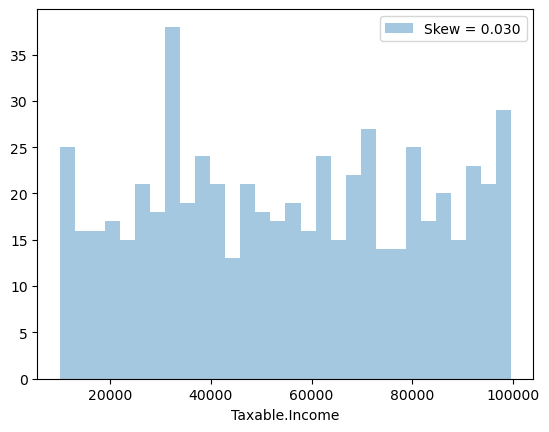

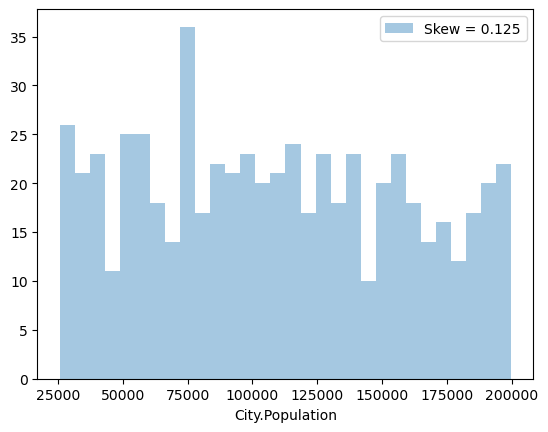

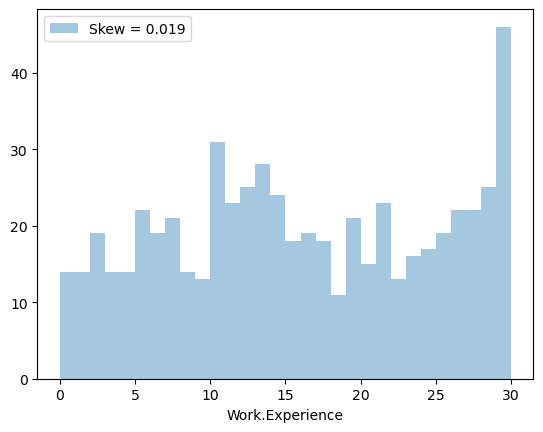

In [14]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [15]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 0 observations with more than 2 outliers


##### Mmm hmm! there exists no observations with multiple outliers. 

Let's examine the boxplots for the several distributions

In [16]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

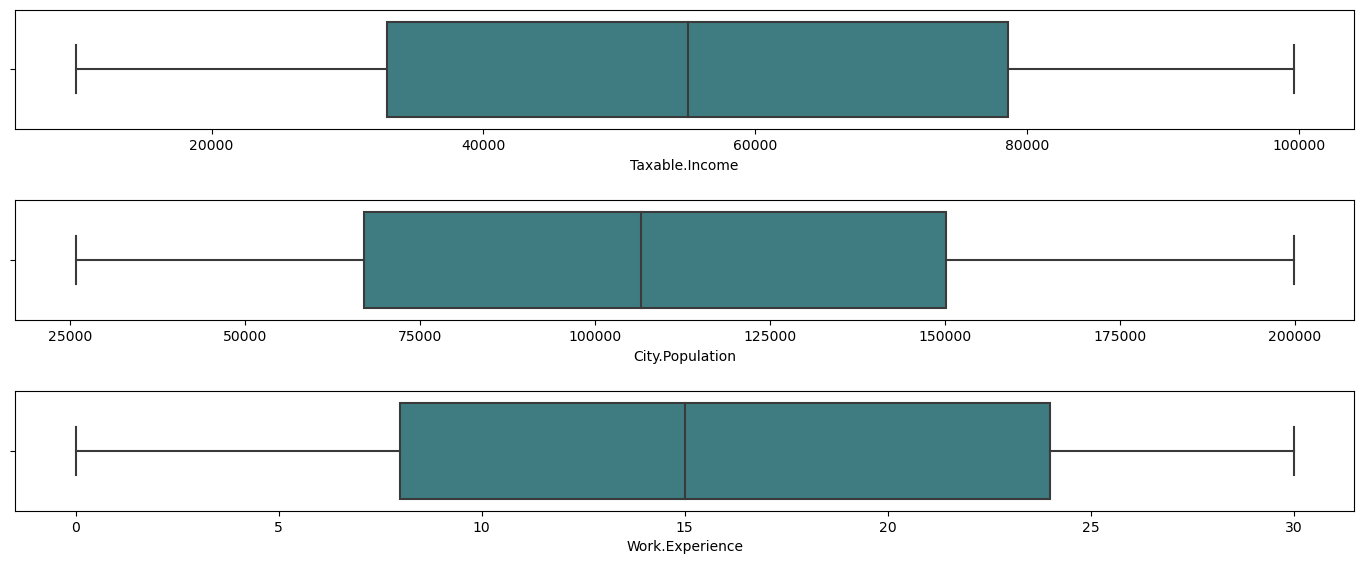

In [17]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

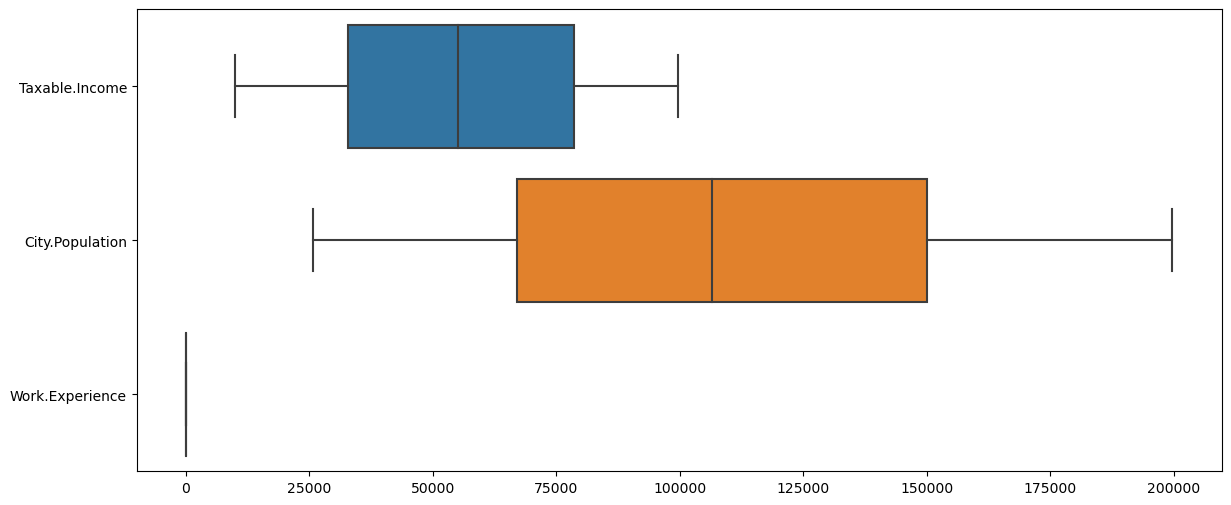

In [18]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h");

#### Unsurprisingly, **`Work.Experience`** has a mean that is much inferior to the other constituents as we already saw in the previous section.

[Table of Contents](#0.1)

+ ### Multivariate Analysis<a class="anchor" id="4.2"></a>


Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

<Figure size 800x800 with 0 Axes>

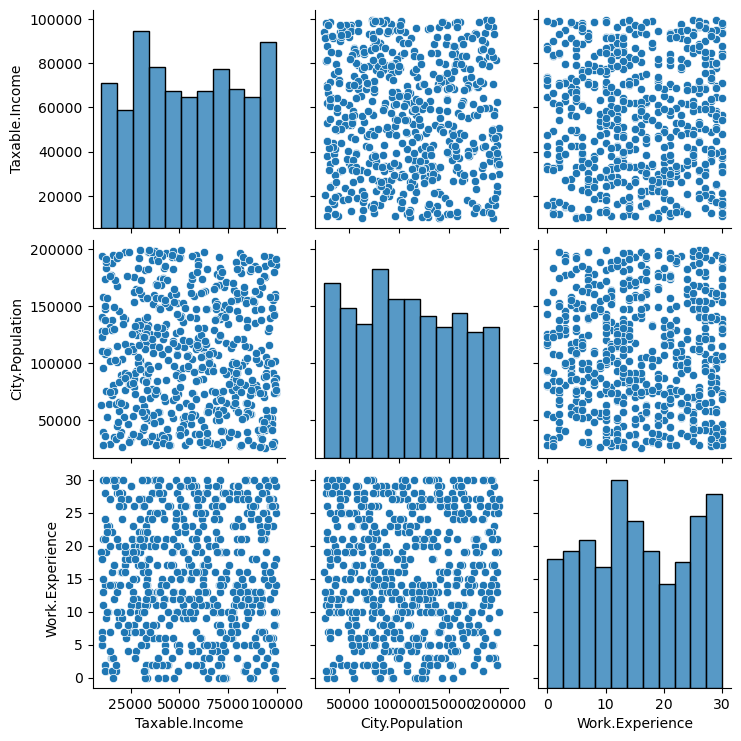

In [19]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

***Pearson's Correlation Coefficient***: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt



<Axes: >

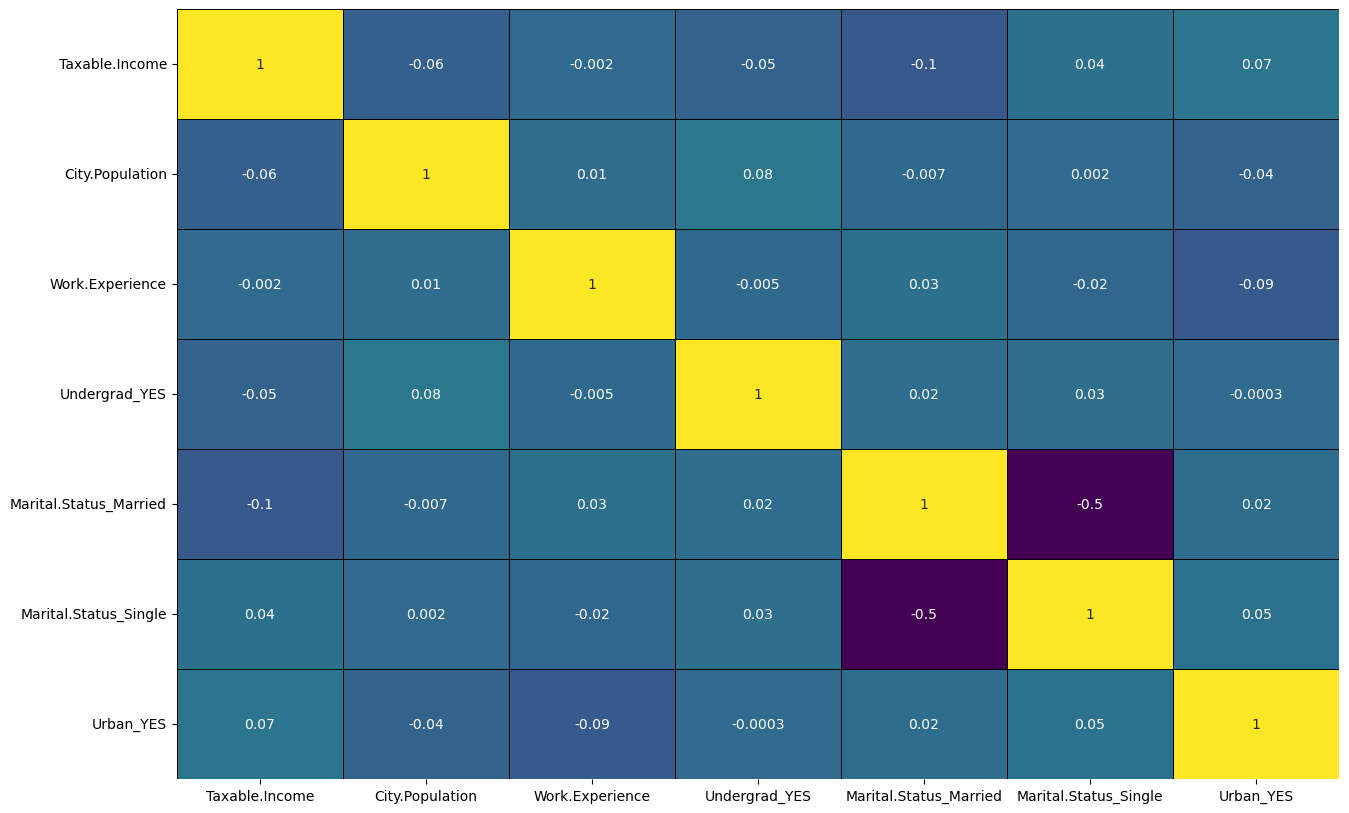

In [21]:
categorical_columns = ['Undergrad', 'Marital.Status', 'Urban']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')


Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


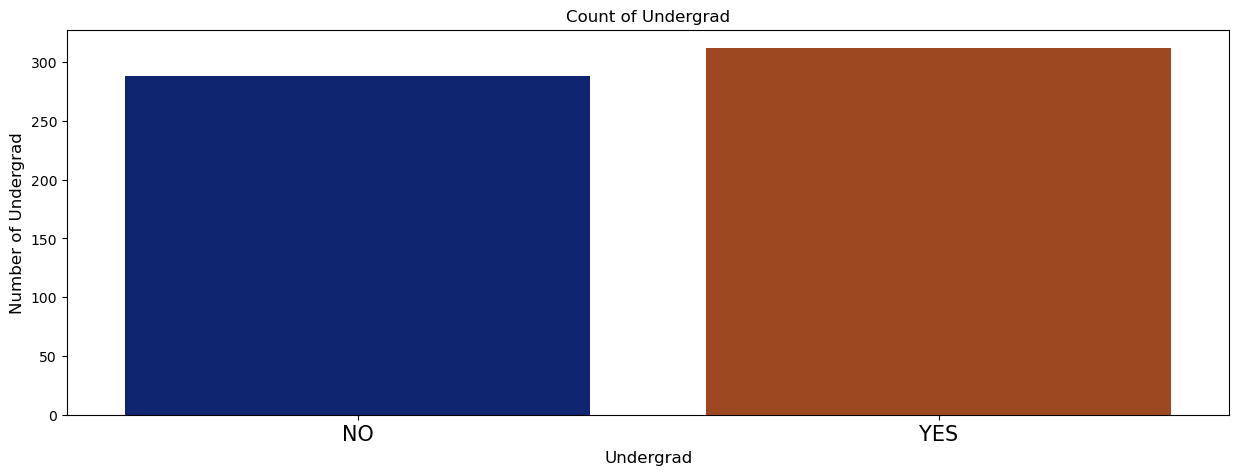

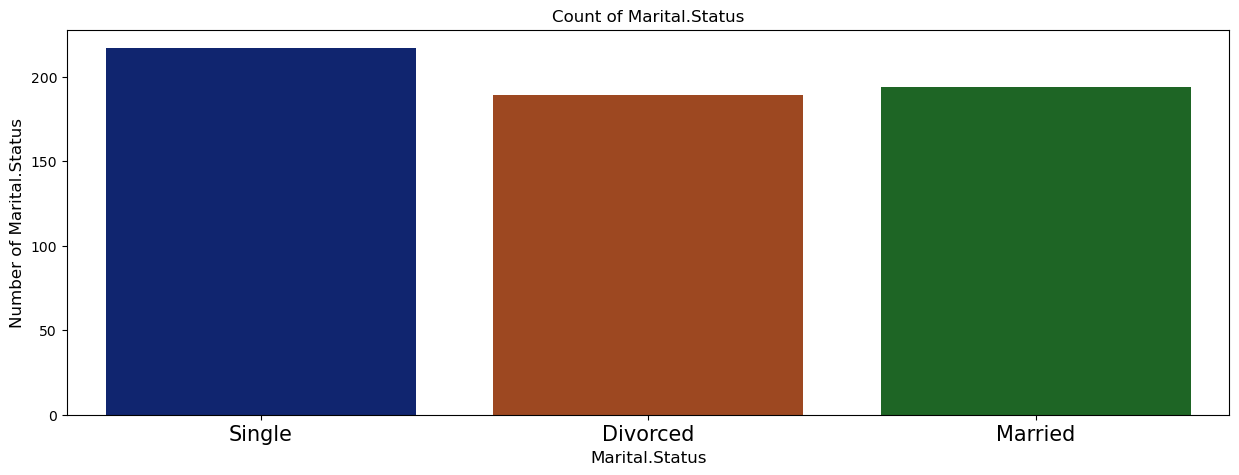

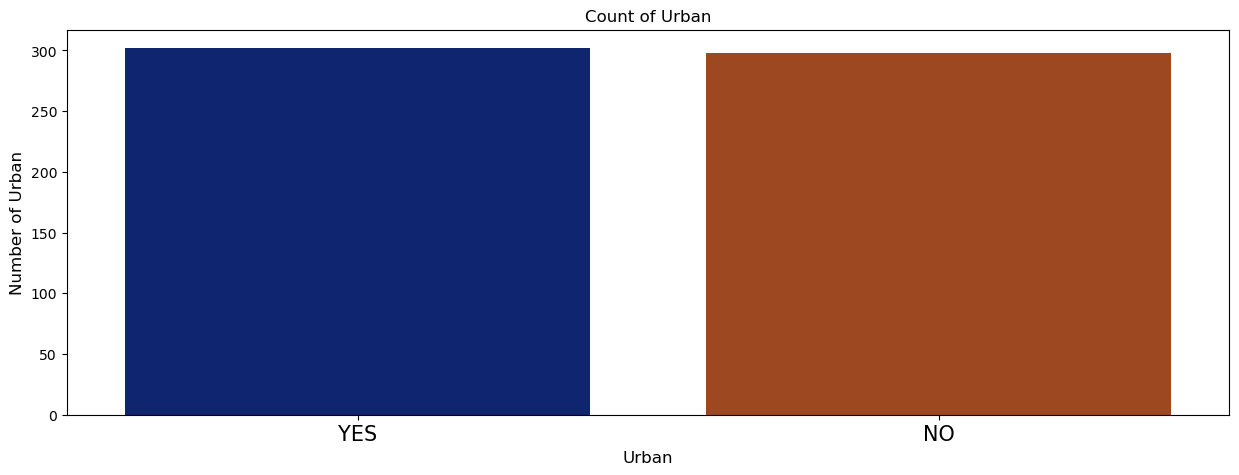

In [22]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def factorplot(param):
    sns.catplot(x=param, y="Taxable.Income", kind="bar", height=7, aspect=2, data=df, palette="dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Taxable Income\n")
    plt.show()


In [24]:
def factorplot(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "Taxable.Income", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Sales\n")
    plt.show()

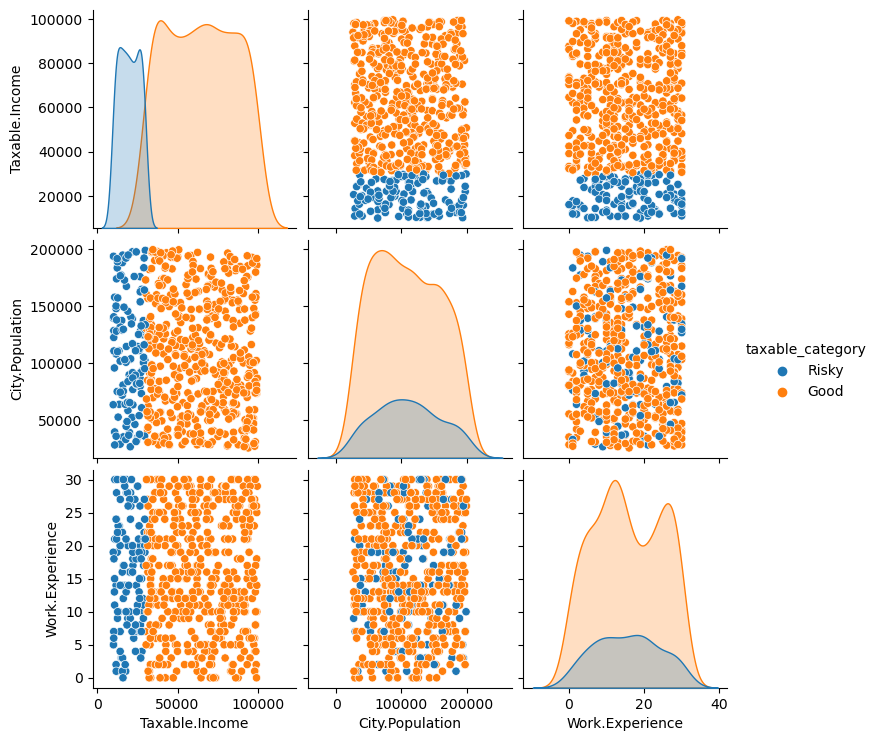

In [25]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

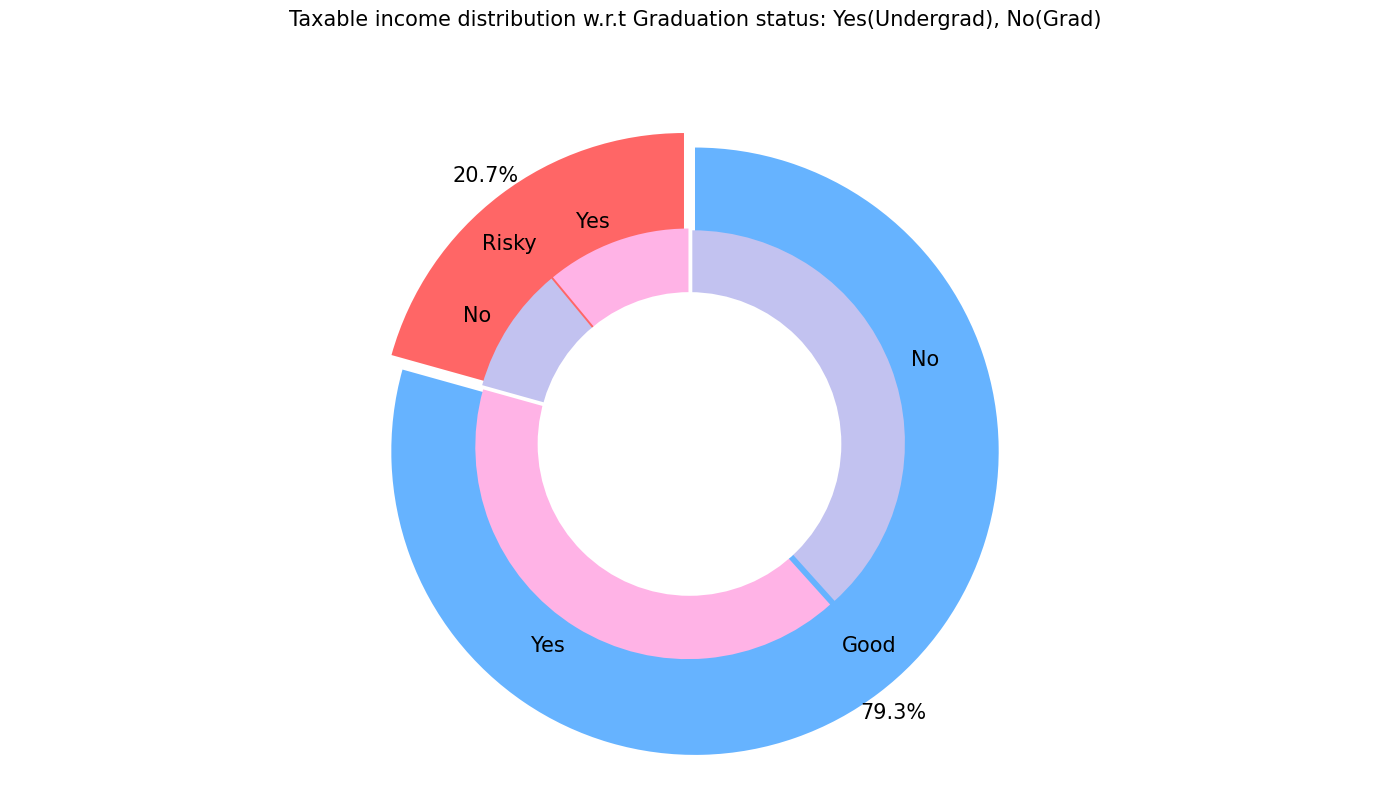

In [26]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Undergrad).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

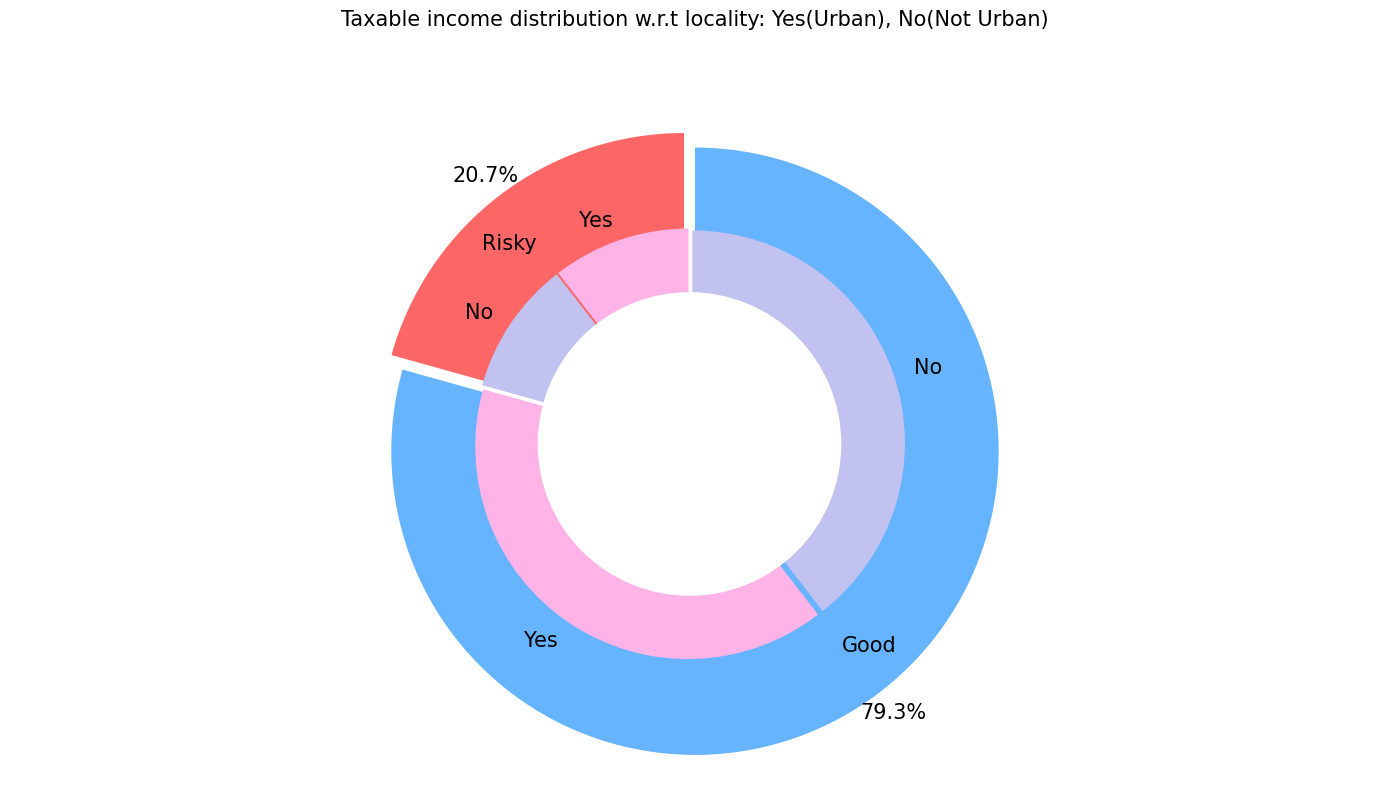

In [27]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Urban).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

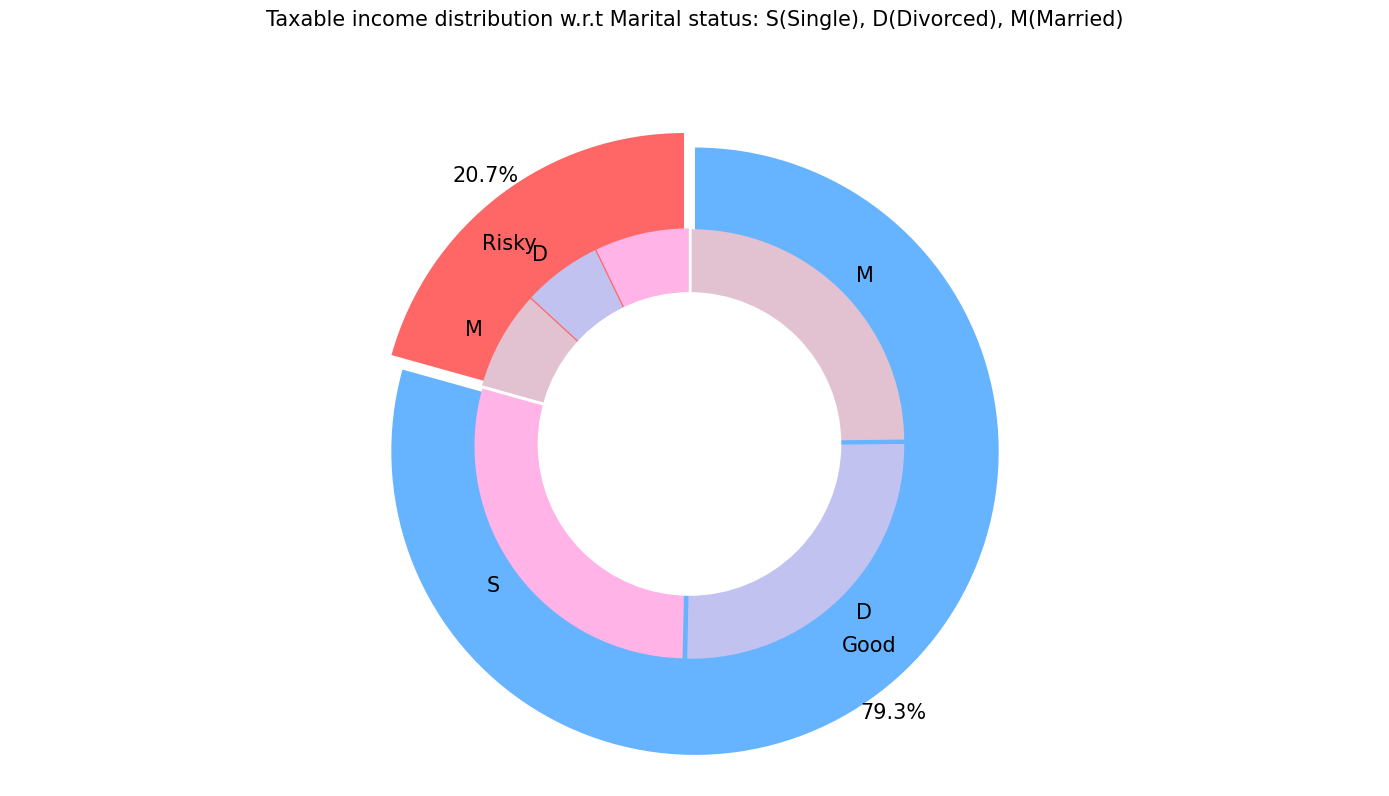

In [28]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1["Marital.Status"]).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Checking for Imbalanced or balanced dataset with regards to the Target

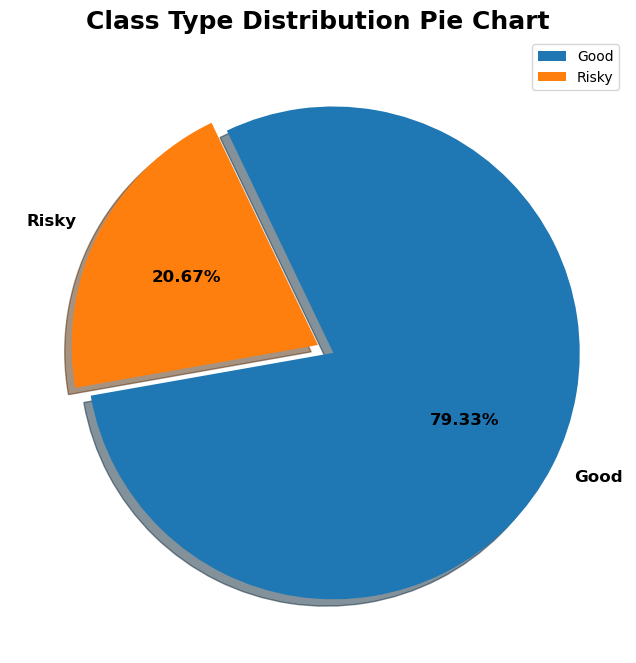

In [29]:
plt.figure(figsize=(12, 8))
plt.pie(df1['taxable_category'].value_counts(),
        labels=df1.taxable_category.unique(),
        explode=[0.07, 0.0],
        autopct='%.2f%%',
        shadow=True,
        startangle=190,
        textprops={'size': 'large',
                   'fontweight': 'bold',
                   'color': 'black'})
plt.legend(loc='upper right')
plt.title("Class Type Distribution Pie Chart", fontsize=18, fontweight='bold')
plt.show()


##### Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.

Here, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [30]:
countNotermdeposit = len(df1[df1["taxable_category"] == 'Good'])
counthavetermdeposit = len(df1[df1["taxable_category"] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [31]:
df1.taxable_category.value_counts()

taxable_category
Good     476
Risky    124
Name: count, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

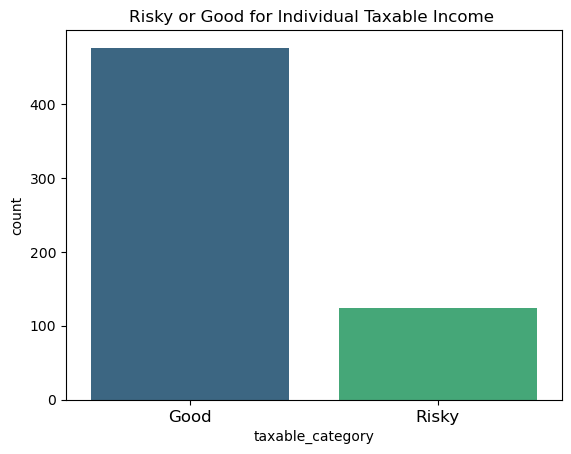

In [32]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

### Problems with imbalanced data classification
If we explain it in a very simple manner, the main problem with imbalanced dataset prediction is how accurately are we actually predicting both majority and minority class?

Sometimes when the records of a certain class are much more than the other class, our classifier may get biased towards the prediction. In this case, the confusion matrix for the classification problem shows how well our model classifies the target classes and we arrive at the accuracy of the model from the confusion matrix.

It is calculated based on the total no of correct predictions by the model divided by the total no of predictions. In the an example case it is (0+95)/(0+95+0+5)=0.95 or 95%. It means that the model fails to identify the minority class yet the accuracy score of the model will be 95%

Thus our traditional approach of classification and model accuracy calculation is not useful in the case of the imbalanced dataset

In [33]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [34]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

Undergrad  Marital_Status  City_Population  Work_Experience  Urban  \
0          0               2            50047               10      1   
1          1               0           134075               18      1   
2          0               1           160205               30      1   
3          1               2           193264               15      1   
4          0               1            27533               28      0   

   taxable_category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [35]:
data.taxable_category.value_counts()

taxable_category
0    476
1    124
Name: count, dtype: int64

In [36]:
x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [37]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
    train, train1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test, test1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train, train1, test, test1))

>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13


In [38]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [39]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=333, 1=87, Test: 0=143, 1=37


In [40]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion": ("gini", "entropy"), 
    "splitter": ("best", "random"), 
    # Add other parameters here
    "min_samples_leaf": list(range(1, 20)), 
}

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)


Fitting 3 folds for each of 76 candidates, totalling 228 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'splitter': ('best', 'random')},
             scoring='accuracy', verbose=1)

In [42]:
from sklearn.metrics import classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"Classification Report:\n{clf_report}")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}\n")
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"Classification Report:\n{clf_report}")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}\n")


In [43]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_X, train_y)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=True)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.44%
Classification Report:
                    0      1  accuracy   macro avg  weighted avg
precision    0.794444    0.0  0.794444    0.397222      0.631142
recall       1.000000    0.0  0.794444    0.500000      0.794444
f1-score     0.885449    0.0  0.794444    0.442724      0.703440
support    429.000000  111.0  0.794444  540.000000    540.000000
Confusion Matrix:
 [[429   0]
 [111   0]]

Test Result:
Accuracy Score: 78.33%
Classification Report:
                   0     1  accuracy  macro avg  weighted avg
precision   0.783333   0.0  0.783333   0.391667      0.613611
recall      1.000000   0.0  0.783333   0.500000      0.783333
f1-score    0.878505   0.0  0.783333   0.439252      0.688162
support    47.000000  13.0  0.783333  60.000000     60.000000
Confusion Matri

In [44]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, train_X, train_y, cv=skf)
print(results.mean())

0.6129629629629629


In [45]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(train_X,train_y)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [46]:
grid.best_score_

0.7944444444444444

In [47]:
predict_output = model.predict(test_X)
accuracy_test = accuracy_score(test_y,predict_output)
accuracy_test

0.7833333333333333

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



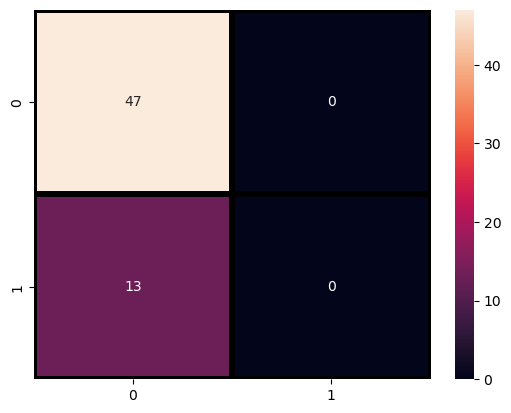

In [48]:
sns.heatmap(confusion_matrix(test_y, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(test_y,predict_output))

In [49]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.29%
Classification Report:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000
Confusion Matrix:
 [[333   0]
 [ 87   0]]

Test Result:
Accuracy Score: 79.44%
Classification Report:
                    0     1  accuracy   macro avg  weighted avg
precision    0.794444   0.0  0.794444    0.397222      0.631142
recall       1.000000   0.0  0.794444    0.500000      0.794444
f1-score     0.885449   0.0  0.794444    0.442724      0.703440
support    143.000000  37.0  0.794444  180.000000    180.000000
Confusion 

In [50]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf)
print(results.mean())

0.6357142857142857


In [51]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(x_train,y_train)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [52]:
grid.best_score_

0.7928571428571429

In [53]:
predict_output = model.predict(x_test)
accuracy_test = accuracy_score(y_test,predict_output)
accuracy_test

0.7944444444444444

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



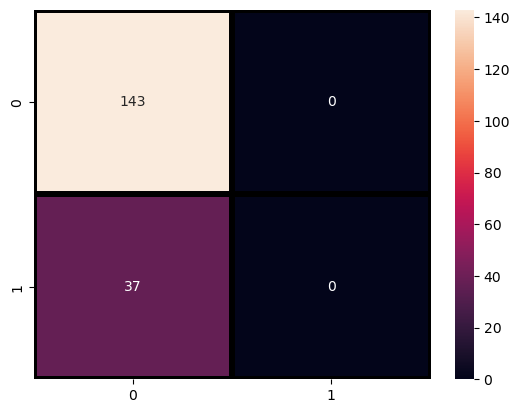

In [54]:
sns.heatmap(confusion_matrix(y_test, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,predict_output))

In [55]:
x = data.drop(['taxable_category'], axis=1)
y = data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [56]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

>Train: 0=333, 1=87, Test: 0=143, 1=37
Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


In [64]:
model_params = {
    'decision_tree' :{
        'model' :  DecisionTreeClassifier(),
        'params' : {
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']
        }
        
    }
    
}

In [66]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 6))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 6)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [ 87   0]]

Test Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.794444   0.0  0.794444    0.397222      0.631142
recall       1.000000   0.0  0.794444    0.500000      0.7

In [67]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

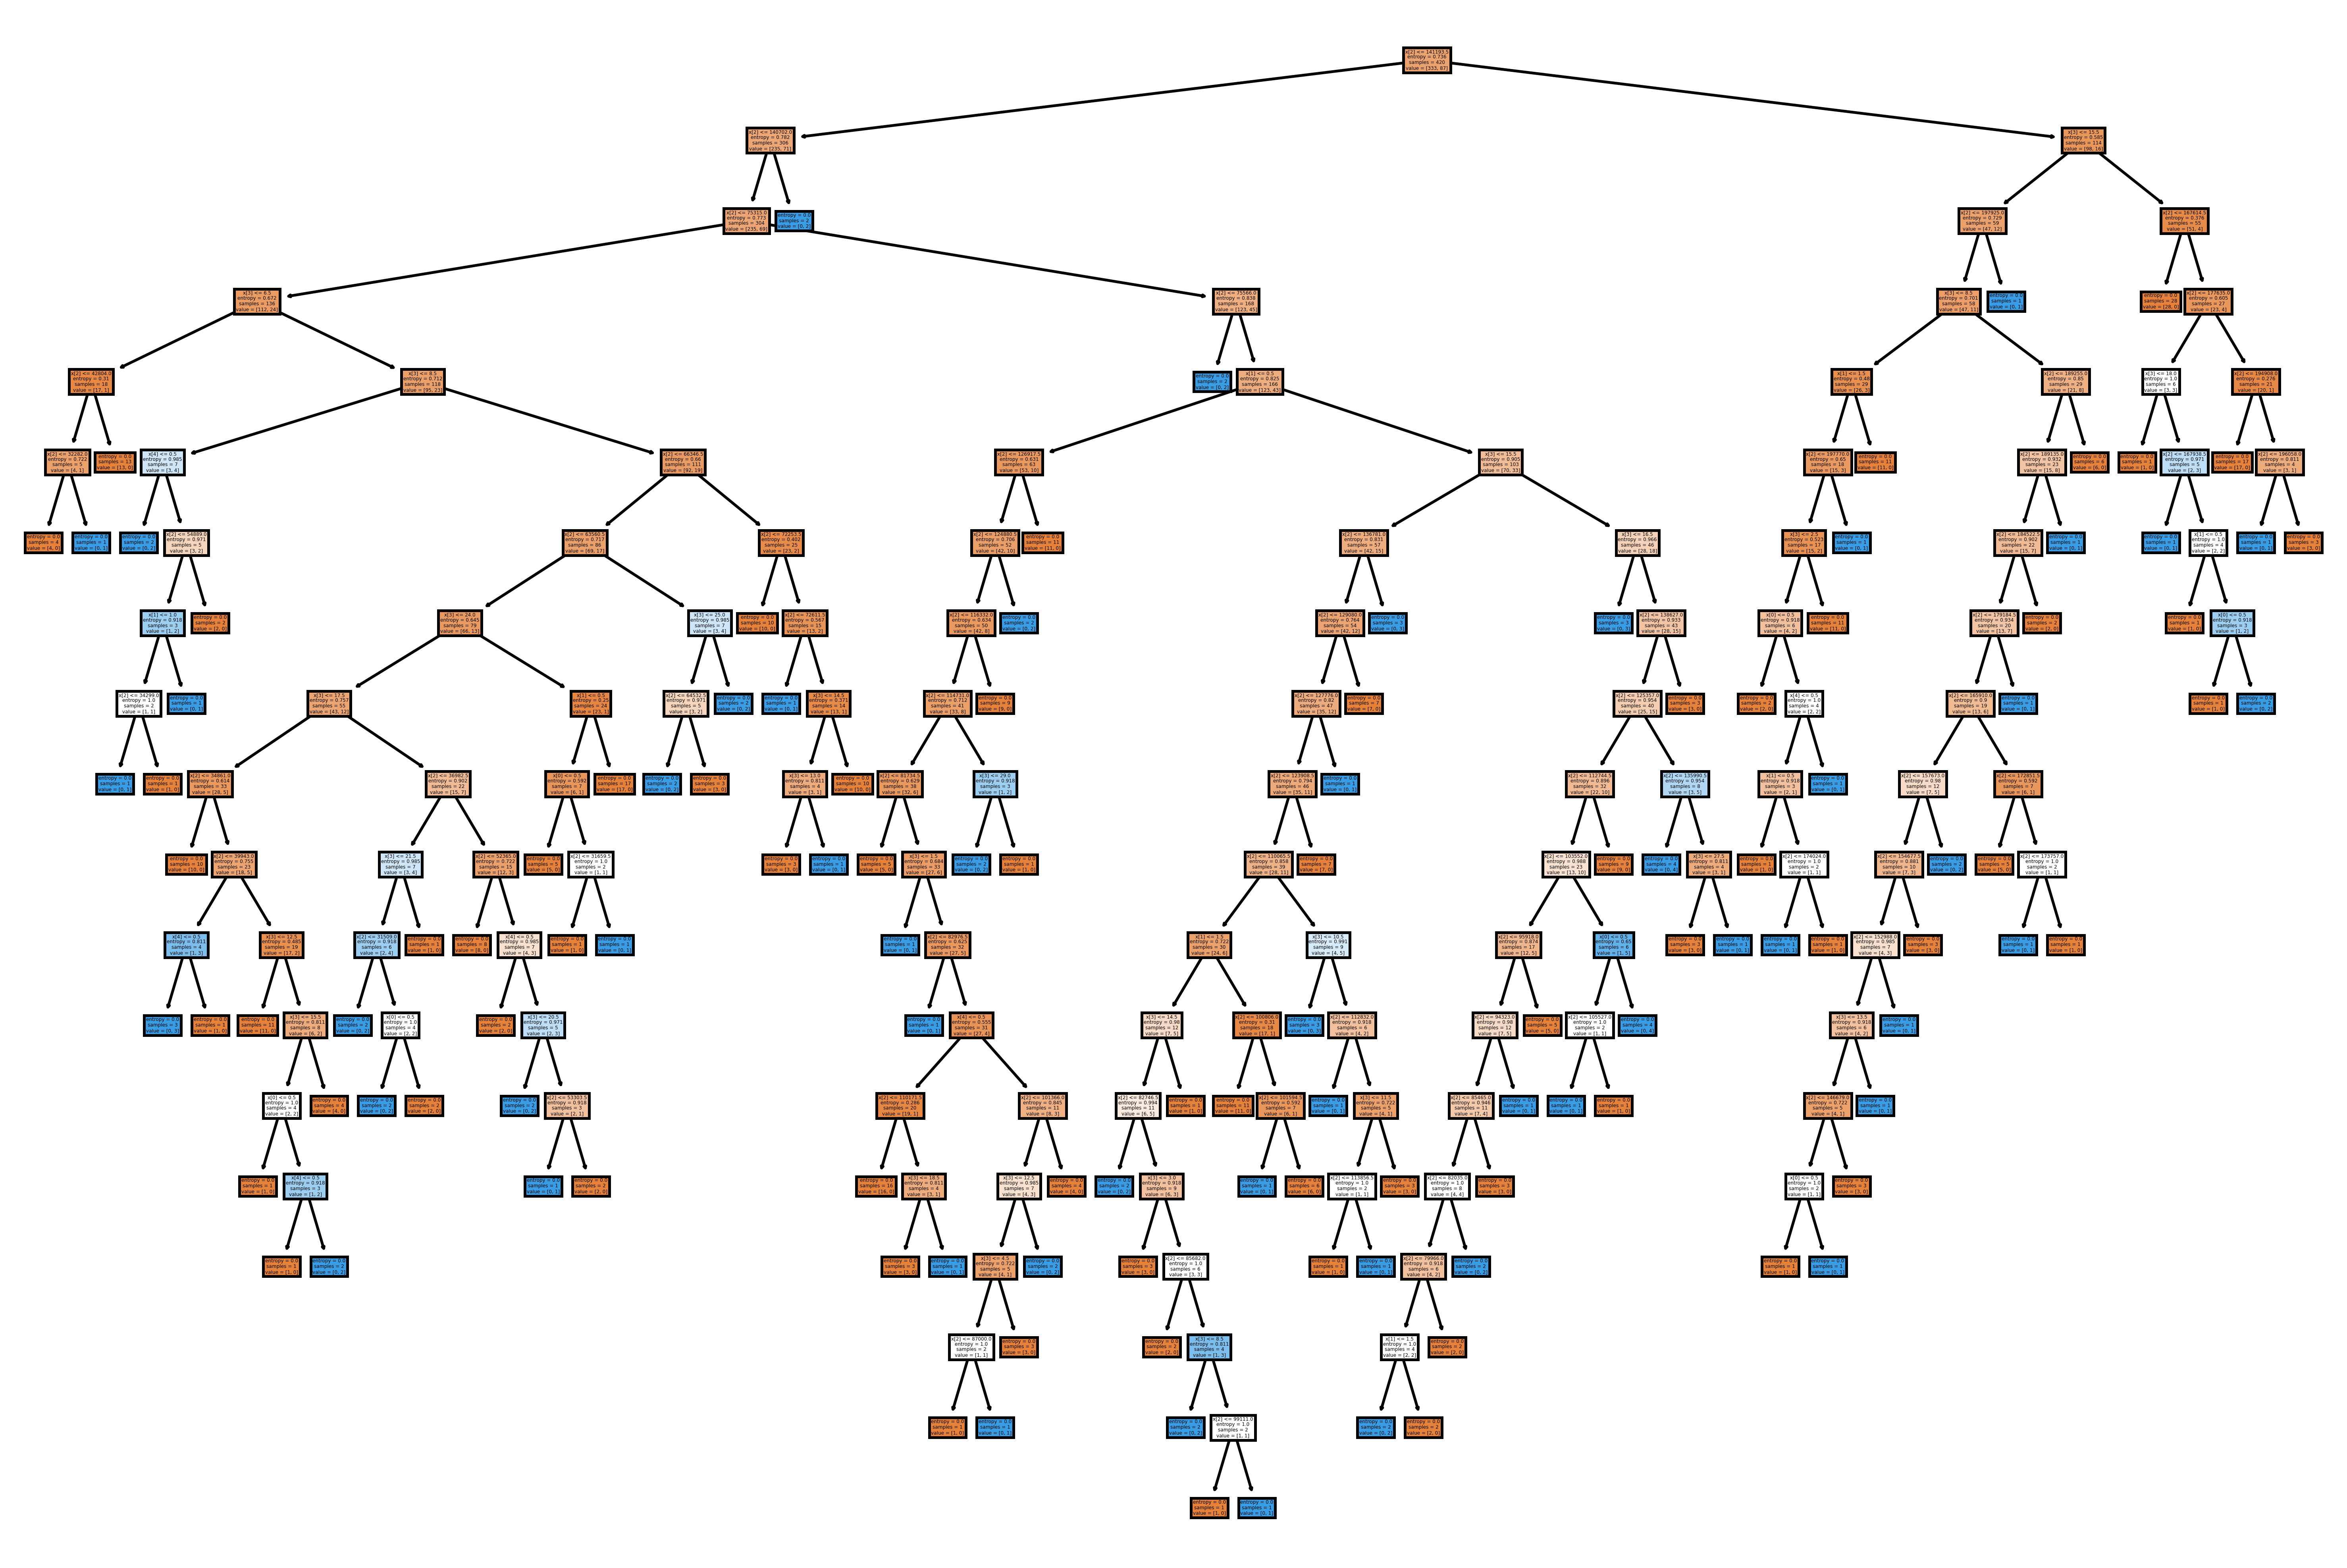

In [68]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [69]:
#Predicting on test data
preds = model_entropy.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    123
1     57
Name: count, dtype: int64

In [70]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0              0   1
taxable_category        
0                 98  45
1                 25  12

In [71]:
# Accuracy 
np.mean(preds==y_test)

0.6111111111111112

In [72]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       143
           1       0.21      0.32      0.26        37

    accuracy                           0.61       180
   macro avg       0.50      0.50      0.50       180
weighted avg       0.68      0.61      0.64       180



In [74]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [75]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.009249011935413321


For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

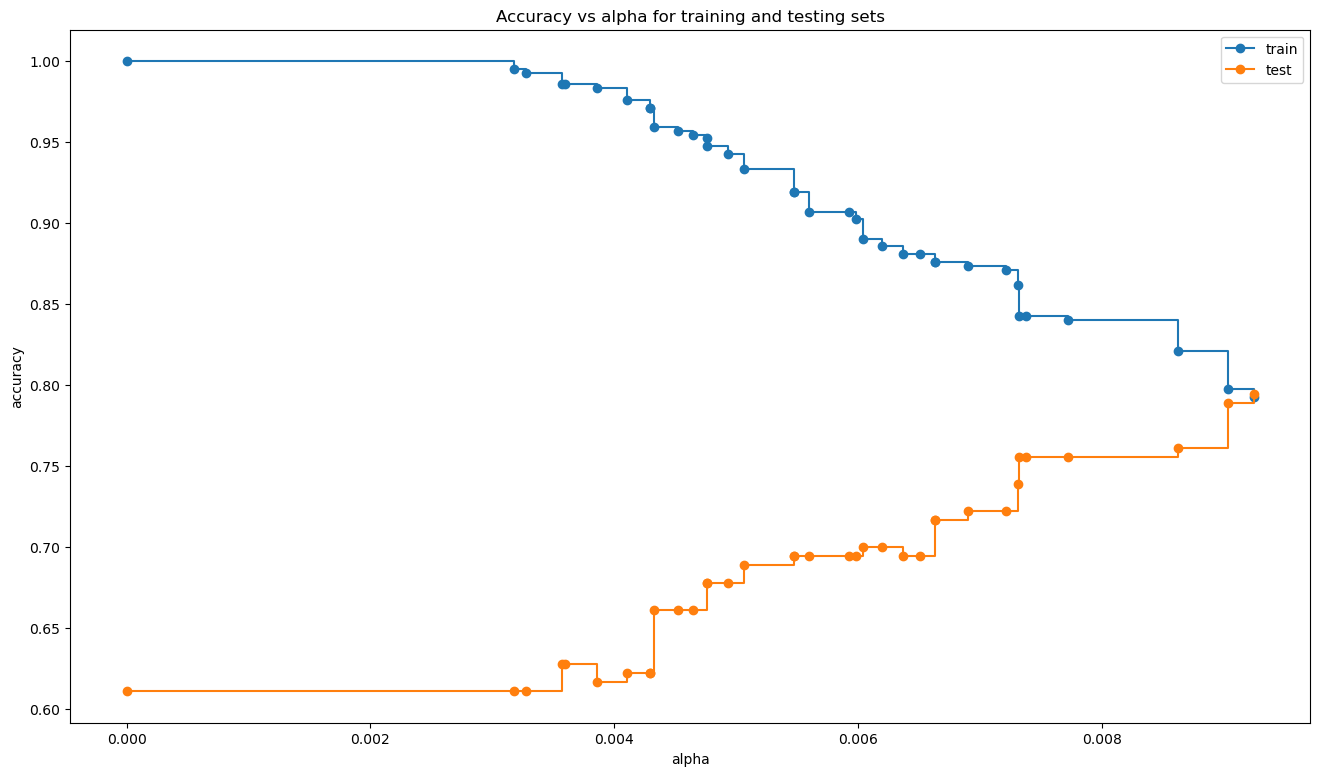

In [76]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [77]:
ccp_alphas

array([0.        , 0.0031746 , 0.00327963, 0.00357143, 0.0035947 ,
       0.00386323, 0.00410512, 0.00429719, 0.00429719, 0.00432797,
       0.00452413, 0.00464302, 0.00475966, 0.0047619 , 0.00493061,
       0.00506745, 0.00547349, 0.00547349, 0.00559925, 0.00592911,
       0.00598481, 0.00604221, 0.00619366, 0.00636602, 0.0065084 ,
       0.00663307, 0.00663307, 0.00690489, 0.00721364, 0.00731233,
       0.00732373, 0.00737917, 0.00772646, 0.00862722, 0.00903738,
       0.00924901])

In [78]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=0.00983548)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00983548, criterion='entropy',
                       random_state=0)

In [79]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7928571428571428 
Testing Accuracy 0.7944444444444444


              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



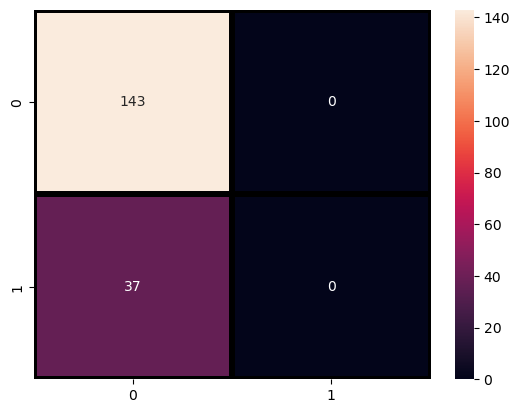

In [80]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

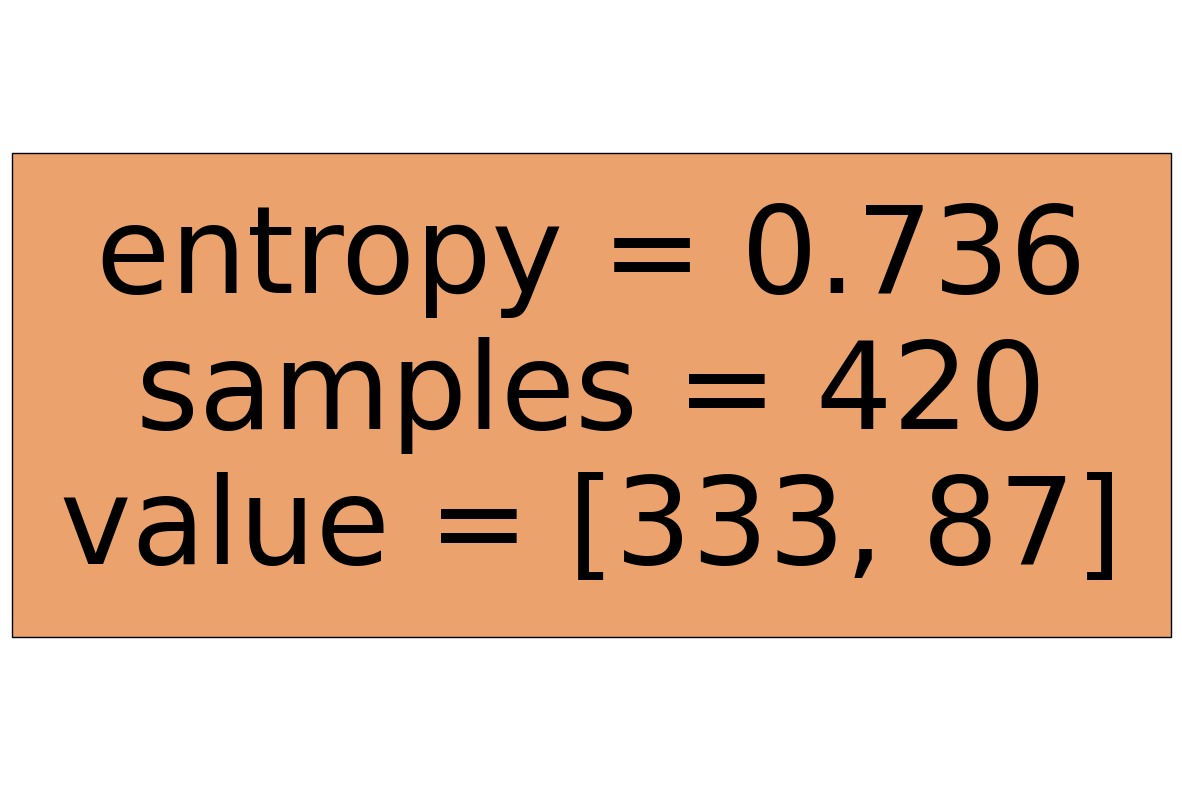

In [81]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()

In [82]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

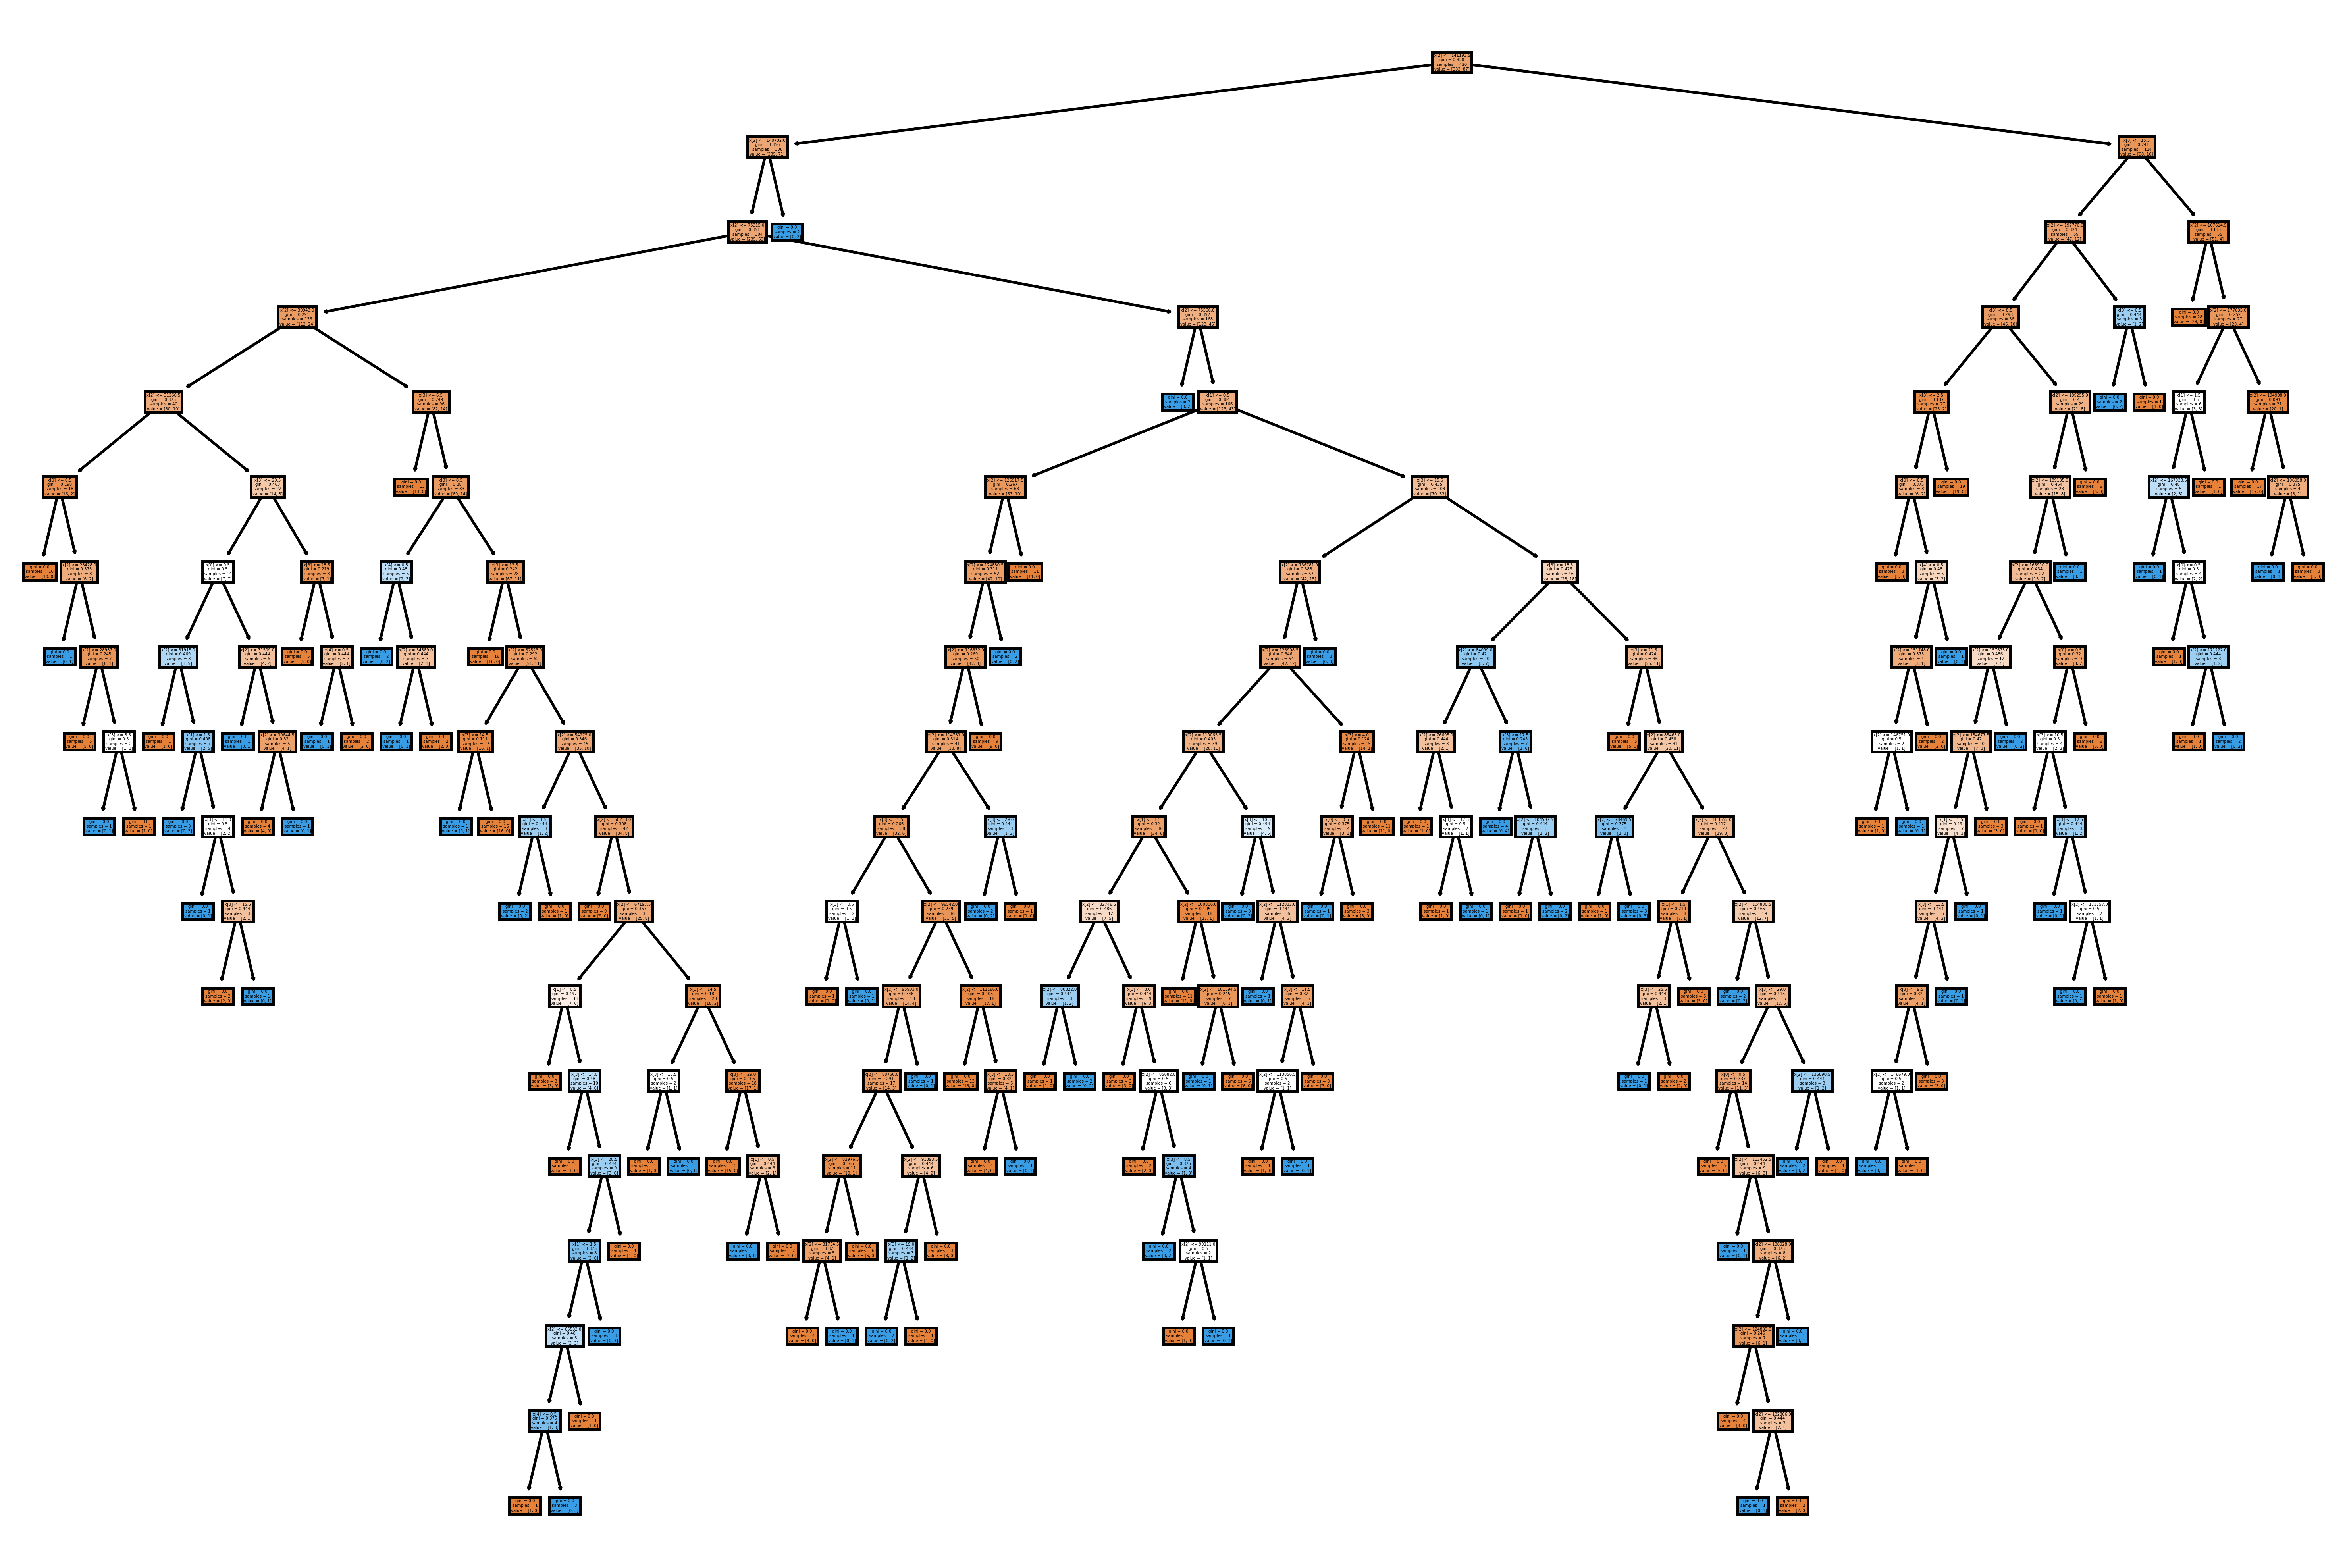

In [83]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_gini,filled=True)
plt.show()

In [84]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    133
1     47
Name: count, dtype: int64

In [85]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0               0   1
taxable_category         
0                 105  38
1                  28   9

In [86]:
# Accuracy 
np.mean(preds==y_test)

0.6333333333333333

In [87]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       143
           1       0.19      0.24      0.21        37

    accuracy                           0.63       180
   macro avg       0.49      0.49      0.49       180
weighted avg       0.67      0.63      0.65       180



In [88]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [89]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.004746761277610458


For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

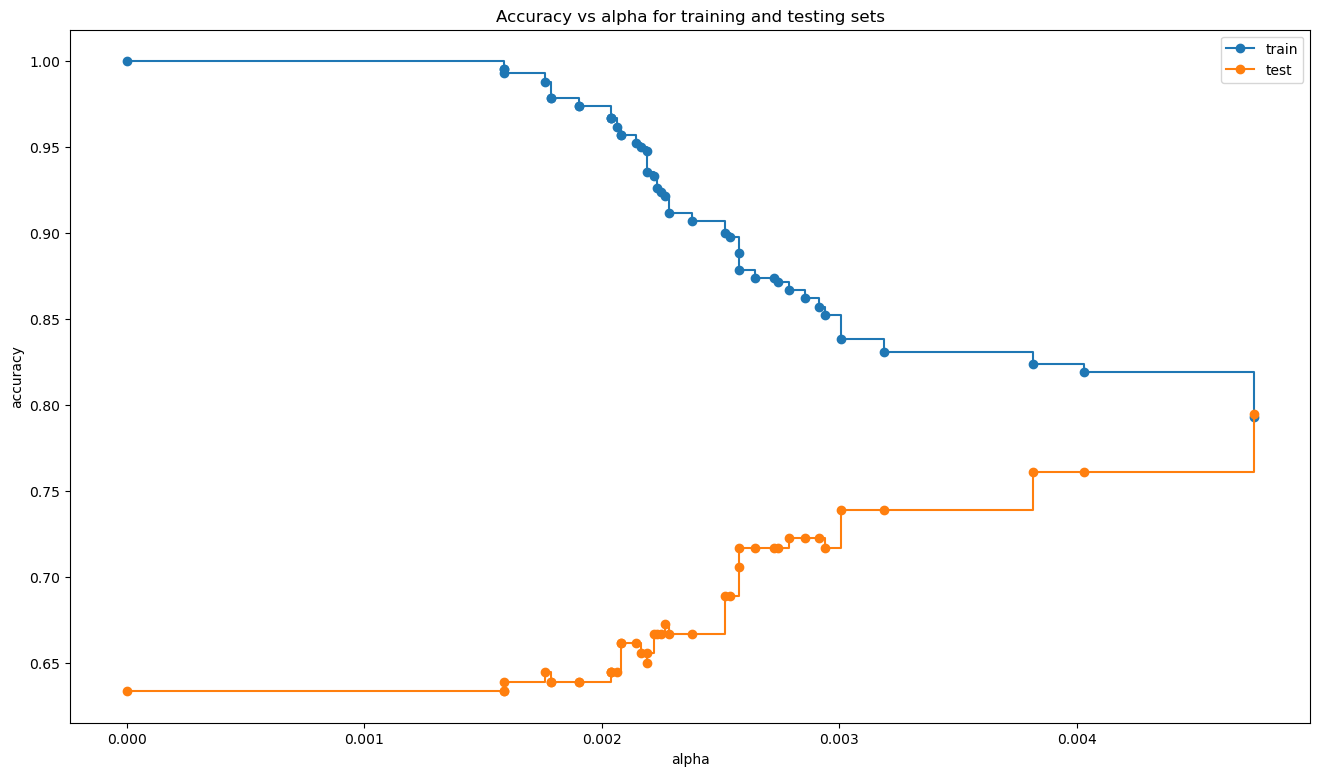

In [90]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [91]:
ccp_alphas

array([0.        , 0.0015873 , 0.0015873 , 0.0015873 , 0.00176367,
       0.00178571, 0.00178571, 0.00190476, 0.00190476, 0.00204082,
       0.00204082, 0.00204082, 0.00206349, 0.00208333, 0.00208333,
       0.00214286, 0.0021645 , 0.00219199, 0.00219235, 0.00222222,
       0.00223214, 0.00224868, 0.00226757, 0.00228571, 0.00238095,
       0.0025207 , 0.00253968, 0.00257937, 0.00257937, 0.00264662,
       0.00272629, 0.00274376, 0.00279112, 0.00285714, 0.00291719,
       0.00294069, 0.00300803, 0.0031893 , 0.00381614, 0.00403023,
       0.00474676])

In [92]:
clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=0.00600582)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00600582, random_state=0)

In [93]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7928571428571428 
Testing Accuracy 0.7944444444444444


              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



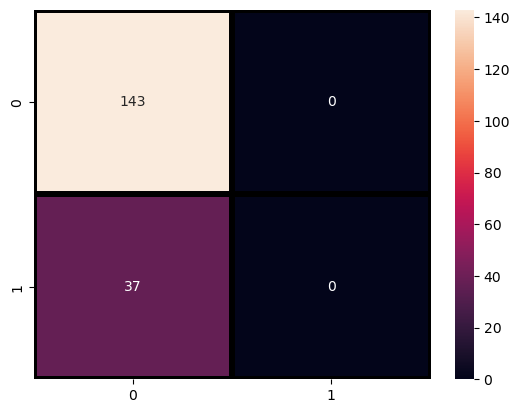

In [94]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

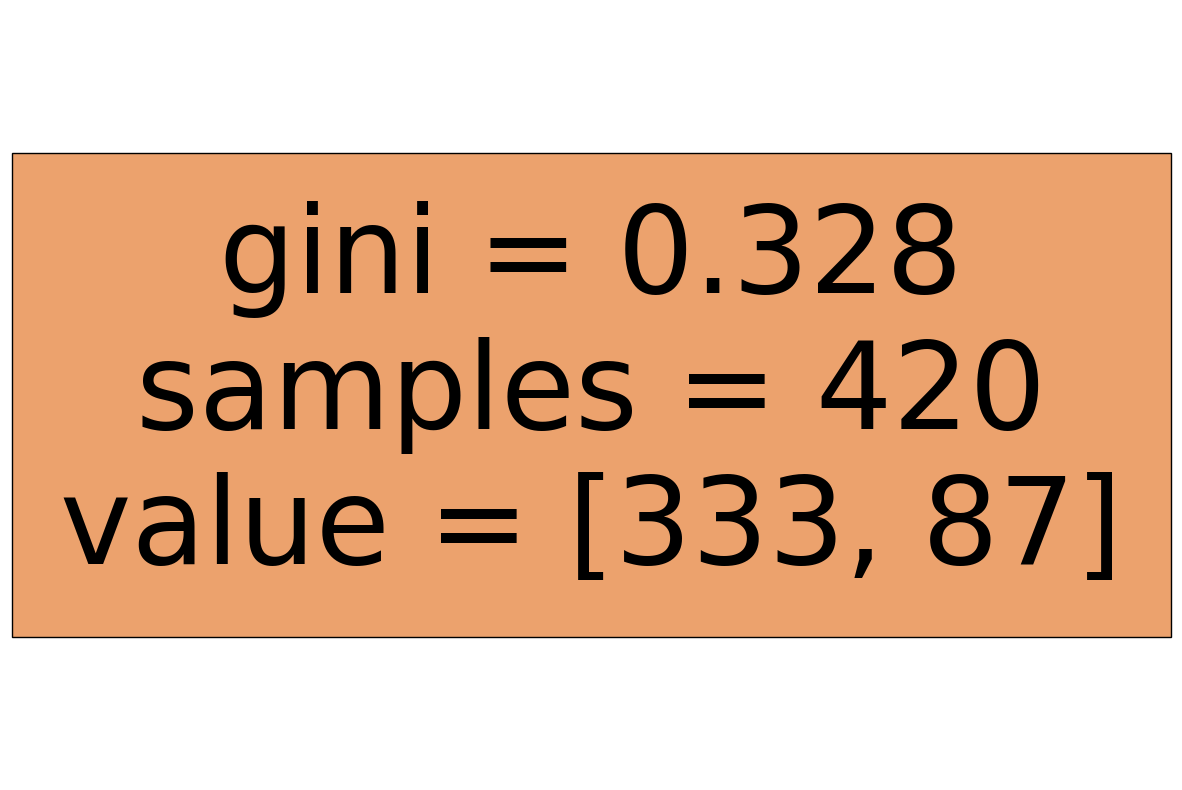

In [95]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()